In [1]:
from posteriordb import PosteriorDatabase
import os
import json
import bridgestan as bs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from stein_thinning.stein import ksd
from stein_thinning.thinning import thin
from stein_thinning.kernel import make_imq, make_centkgm

from stein_pi_thinning.target import PiTargetIMQ, PiTargetCentKGM
from stein_pi_thinning.mcmc import mala_adapt
from stein_pi_thinning.util import flat, comp_wksd, mkdir, nearestPD
from stein_pi_thinning.progress_bar import disable_progress_bar, tqdm

import wasserstein

rng = np.random.default_rng(1234)
disable_progress_bar()

In [2]:
nits = 100_000
model_name = "toy_mvsn_2d"
dbpath = "../posteriordb/posterior_database"
s = 3.0
fixed_ratio = 0.1
iteration_list = [10, 20, 50, 100, 200, 500, 1000]
repeat_times = 10
thinning_method = "weight"

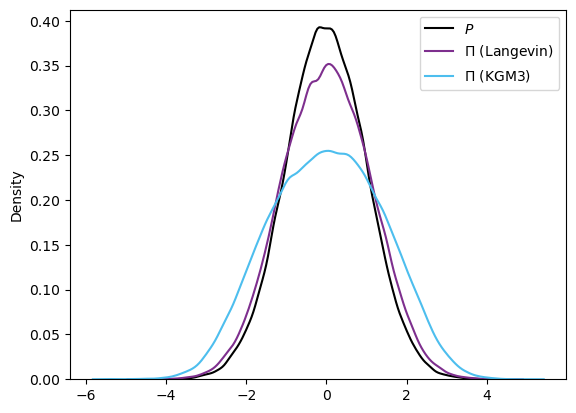

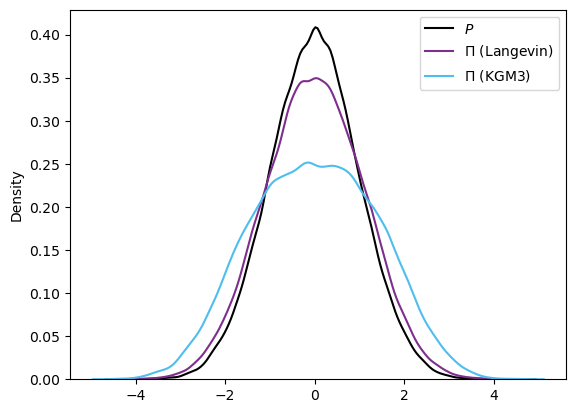

In [3]:
# Model Preparation
## Load DataBase Locally
pdb_path = os.path.join(dbpath)
my_pdb = PosteriorDatabase(pdb_path)

## Load Dataset
posterior = my_pdb.posterior(model_name)
stan = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan, data)

## Gold Standard
gs_list = posterior.reference_draws()
df = pd.DataFrame(gs_list)
gs_constrain = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                    posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    gs_s = []
    for j in range(len(df[df.keys()[i]])):
        gs_s += df[df.keys()[i]][j]
    gs_constrain[i] = gs_s
gs_constrain = gs_constrain.T
gs = np.zeros_like(gs_constrain)
for i in range(gs_constrain.shape[0]):
    gs[i] = model.param_unconstrain(gs_constrain[i].astype(np.float64))
# P Target and Q Target
## Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]

## Generate Q Target
x_unconstrain_map = np.mean(gs, axis=0)
dim = len(x_unconstrain_map)
linv = nearestPD(-hess_log_p(x_unconstrain_map))

stein_q_imq = PiTargetIMQ(log_p, grad_log_p, hess_log_p, linv)
log_q_imq = stein_q_imq.log_q
grad_log_q_imq = stein_q_imq.grad_log_q

stein_q_centkgm = PiTargetCentKGM(log_p, grad_log_p, hess_log_p, linv, s, x_unconstrain_map)
log_q_centkgm = stein_q_centkgm.log_q
grad_log_q_centkgm = stein_q_centkgm.grad_log_q

## MALA With pre-conditioning
### Parameters

alpha = 10 * [1]
epoch = 9 * [1_000] + [nits]

_, _, x_p_epoch, _, _, nacc_p = mala_adapt(log_p, grad_log_p, x_unconstrain_map, 0.1, np.eye(dim), alpha, epoch)
# print('acc_p =', np.mean(nacc_p[-1]))
assert np.mean(nacc_p[-1]) > 0.2, "Acceptance rate is too low"

_, _, x_q_imq_epoch, _, _, nacc_q = mala_adapt(log_q_imq, grad_log_q_imq, x_unconstrain_map, 0.1, np.eye(dim), alpha, epoch)
# print('acc_q =', np.mean(nacc_q[-1]))
assert np.mean(nacc_q[-1]) > 0.2, "Acceptance rate is too low"

_, _, x_q_centkgm_epoch, _, _, nacc_q = mala_adapt(log_q_centkgm, grad_log_q_centkgm, x_unconstrain_map, 0.1, np.eye(dim), alpha, epoch)
# print('acc_q =', np.mean(nacc_q[-1]))
assert np.mean(nacc_q[-1]) > 0.2, "Acceptance rate is too low"

x_p_unconstrain = np.array(x_p_epoch[-1], dtype=np.float64)
grad_x_p_unconstrain = np.array([grad_log_p(i) for i in x_p_unconstrain])

x_q_imq_unconstrain = np.array(x_q_imq_epoch[-1], dtype=np.float64)
grad_x_q_imq_unconstrain = np.array([grad_log_p(i) for i in x_q_imq_unconstrain])

x_q_centkgm_unconstrain = np.array(x_q_centkgm_epoch[-1], dtype=np.float64)
grad_x_q_centkgm_unconstrain = np.array([grad_log_p(i) for i in x_q_centkgm_unconstrain])

### Create Folder
save_path = f"Pic/{model_name}"
mkdir(save_path)
### Plotting P and Q
for i in range(dim):
    plt.cla()
    sns.kdeplot(x_p_unconstrain[:,i].flatten(), label='$P$', color="black")
    sns.kdeplot(x_q_imq_unconstrain[:,i].flatten(), label='$\Pi$ (Langevin)', color="#7e2f8e")
    sns.kdeplot(x_q_centkgm_unconstrain[:,i].flatten(), label='$\Pi$ (KGM3)', color="#4dbeee")

    plt.legend()
    plt.show()

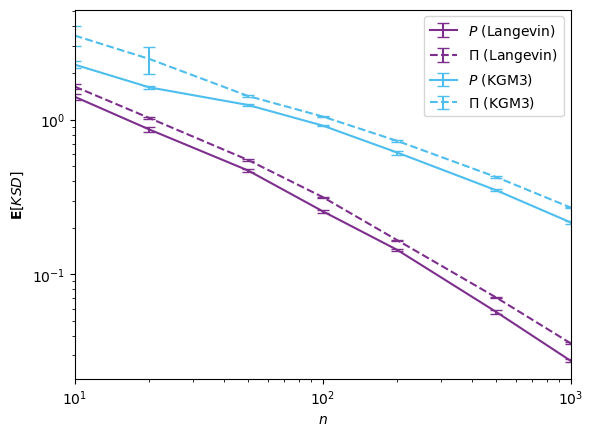

In [4]:
# Thinning
## Kernel Selection
vfk0_imq = make_imq(x_p_unconstrain, grad_x_p_unconstrain, pre=linv)
vfk0_centkgm = make_centkgm(x_p_unconstrain, grad_x_p_unconstrain, x_map=x_unconstrain_map.reshape(1,-1), pre=linv, s=s)

## Store
### KSD IMQ
res_ksd_p_imq_wt = np.zeros((repeat_times, len(iteration_list)))
res_ksd_p_centkgm_wt = np.zeros((repeat_times, len(iteration_list)))
res_ksd_q_imq_wt = np.zeros((repeat_times, len(iteration_list)))
res_ksd_q_centkgm_wt = np.zeros((repeat_times, len(iteration_list)))

## Thinning Method Selection
for i in range(repeat_times):
    start_position = rng.integers(0, nits-np.max(iteration_list))
    for j_index, j in enumerate(iteration_list):
        thinning_number = int(fixed_ratio * j)
        ### P
        x_p_unconstrain_cutting = x_p_unconstrain[start_position:start_position+j,:]
        grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[start_position:start_position+j,:]
        ### IMQ
        x_q_imq_unconstrain_cutting = x_q_imq_unconstrain[start_position:start_position+j,:]
        grad_x_q_imq_unconstrain_cutting = grad_x_q_imq_unconstrain[start_position:start_position+j,:]
        ### KGM
        x_q_centkgm_unconstrain_cutting = x_q_centkgm_unconstrain[start_position:start_position+j,:]
        grad_x_q_centkgm_unconstrain_cutting = grad_x_q_centkgm_unconstrain[start_position:start_position+j,:]

        idx_p_imq = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False,\
                    kern='imq'
                )
        idx_q_imq = thin(x_q_imq_unconstrain_cutting,\
                    grad_x_q_imq_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False,\
                    kern='imq'
                )
        idx_p_centkgm = thin(x_p_unconstrain_cutting,\
                        grad_x_p_unconstrain_cutting,\
                        thinning_number,\
                        pre=linv,\
                        stnd=False,
                        kern='centkgm',
                        xmp=x_unconstrain_map
                    )
        idx_q_centkgm = thin(x_q_centkgm_unconstrain_cutting,\
                        grad_x_q_centkgm_unconstrain_cutting,\
                        thinning_number,\
                        pre=linv,\
                        stnd=False,
                        kern='centkgm',
                        xmp=x_unconstrain_map
                    )

        ### Thin m = 0.1 * n points
        x_p_imq_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p_imq]
        grad_x_p_imq_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p_imq]

        x_p_centkgm_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p_centkgm]
        grad_x_p_centkgm_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p_centkgm]

        x_q_imq_thinning_unconstrain_cutting = x_q_imq_unconstrain_cutting[idx_q_imq]
        grad_x_q_imq_thinning_unconstrain_cutting = grad_x_q_imq_unconstrain_cutting[idx_q_imq]

        x_q_centkgm_thinning_unconstrain_cutting = x_q_centkgm_unconstrain_cutting[idx_q_centkgm]
        grad_x_q_centkgm_thinning_unconstrain_cutting = grad_x_q_centkgm_unconstrain_cutting[idx_q_centkgm]

        ### Randomly no put-back subsampled m = 0.1 * n points from MALA of length n
        x_p_imq_thinning_unconstrain_choice = rng.choice(x_p_unconstrain_cutting, size=thinning_number, replace=False, shuffle=True)
        x_p_centkgm_thinning_unconstrain_choice = rng.choice(x_p_unconstrain_cutting, size=thinning_number, replace=False, shuffle=True)
        x_q_imq_thinning_unconstrain_choice = rng.choice(x_q_imq_thinning_unconstrain_cutting, size=thinning_number, replace=False, shuffle=True)
        x_q_centkgm_thinning_unconstrain_choice = rng.choice(x_q_centkgm_thinning_unconstrain_cutting, size=thinning_number, replace=False, shuffle=True)

        ### Mixed into a total subsample of 2m in length
        x_p_imq_thinning_unconstrain_mix = np.concatenate((x_p_imq_thinning_unconstrain_cutting, x_p_imq_thinning_unconstrain_choice), axis=0)
        x_p_centkgm_thinning_unconstrain_mix = np.concatenate((x_p_centkgm_thinning_unconstrain_cutting, x_p_centkgm_thinning_unconstrain_choice), axis=0)
        x_q_imq_thinning_unconstrain_mix = np.concatenate((x_q_imq_thinning_unconstrain_cutting, x_q_imq_thinning_unconstrain_choice), axis=0)
        x_q_centkgm_thinning_unconstrain_mix = np.concatenate((x_q_centkgm_thinning_unconstrain_cutting, x_q_centkgm_thinning_unconstrain_choice), axis=0)

        grad_x_p_imq_thinning_unconstrain_mix = np.array([grad_log_p(i) for i in x_p_imq_thinning_unconstrain_mix])
        grad_x_p_centkgm_thinning_unconstrain_mix = np.array([grad_log_p(i) for i in x_p_centkgm_thinning_unconstrain_mix])
        grad_x_q_imq_thinning_unconstrain_mix = np.array([grad_log_p(i) for i in x_q_imq_thinning_unconstrain_mix])
        grad_x_q_centkgm_thinning_unconstrain_mix = np.array([grad_log_p(i) for i in x_q_centkgm_thinning_unconstrain_mix])

        ### Weighted KSD Calculation
        res_ksd_p_imq_wt[i, j_index] = comp_wksd(x_p_imq_thinning_unconstrain_mix, grad_x_p_imq_thinning_unconstrain_mix, vfk0_imq)
        res_ksd_p_centkgm_wt[i, j_index] = comp_wksd(x_p_centkgm_thinning_unconstrain_mix, grad_x_p_centkgm_thinning_unconstrain_mix, vfk0_centkgm)
        res_ksd_q_imq_wt[i, j_index] = comp_wksd(x_q_imq_thinning_unconstrain_mix, grad_x_q_imq_thinning_unconstrain_mix, vfk0_imq)
        res_ksd_q_centkgm_wt[i, j_index] = comp_wksd(x_q_centkgm_thinning_unconstrain_mix, grad_x_q_centkgm_thinning_unconstrain_mix, vfk0_centkgm)

mean_ksd_p_imq_wt = np.mean(res_ksd_p_imq_wt, axis=0)
std_error_ksd_p_imq_wt = repeat_times ** (-1/2) * np.std(res_ksd_p_imq_wt, axis=0)
mean_ksd_q_imq_wt = np.mean(res_ksd_q_imq_wt, axis=0)
std_error_ksd_q_imq_wt = repeat_times ** (-1/2) * np.std(res_ksd_q_imq_wt, axis=0)

mean_ksd_p_centkgm_wt = np.mean(res_ksd_p_centkgm_wt, axis=0)
std_error_ksd_p_centkgm_wt = repeat_times ** (-1/2) * np.std(res_ksd_p_centkgm_wt, axis=0)
mean_ksd_q_centkgm_wt = np.mean(res_ksd_q_centkgm_wt, axis=0)
std_error_ksd_q_centkgm_wt = repeat_times ** (-1/2) * np.std(res_ksd_q_centkgm_wt, axis=0)

plt.cla()

plt.errorbar(iteration_list, mean_ksd_p_imq_wt, yerr=std_error_ksd_p_imq_wt, color="#7e2f8e", linestyle="-", capsize=4, label="$P$ (Langevin)")
plt.errorbar(iteration_list, mean_ksd_q_imq_wt, yerr=std_error_ksd_q_imq_wt, color="#7e2f8e", linestyle="--", capsize=4, label="$\Pi$ (Langevin)")

plt.errorbar(iteration_list, mean_ksd_p_centkgm_wt, yerr=std_error_ksd_p_centkgm_wt, color="#4dbeee", linestyle="-", capsize=4, label="$P$ (KGM3)")
plt.errorbar(iteration_list, mean_ksd_q_centkgm_wt, yerr=std_error_ksd_q_centkgm_wt, color="#4dbeee", linestyle="--", capsize=4, label="$\Pi$ (KGM3)")

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$n$')
plt.ylabel(r"$\bf{E}$[$KSD$]")

plt.xlim((np.min(iteration_list), np.max(iteration_list)))

plt.legend()
plt.savefig(f"{model_name}_wt.pdf")